# Fisher Information fits (2016)

This is a redo of Figure 7 in the paper, but using the last codebase.

Need to check:

* What is the Fisher Info that was really used
* If we need T or T-1 in the theoretical thing.

Later:

* Extend this to multiple objects and redo similar plots for Thesis.


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa
import sampler_invtransf_randomfactorialnetwork
import highdimensionnetwork

from scipy.spatial.distance import pdist

# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})

In [4]:
%cd '/nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory'

/nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory


In [5]:
arguments_dict = dict(
    action_to_do='launcher_check_fisher_fit_1obj_2016',
    collect_responses=None,
    inference_method='sample',
    N=200,
    num_samples=50,
    M=14**2,
    T=1,
    num_repetitions=3,
    renormalize_sigma=None,
#     rc_scale = 4.,
    autoset_parameters=None,
    label='thesis_fisherinfo_fit_1obj',
    code_type='conj',
    output_directory='./Experiments/fisherinfo_singleitem/thesisrerun_fisherinfo_fit_1obj_050816',
    ratio_conj=1.,
    sigmax=0.25,
    sigma_baseline=0.0,
    sigmay=0.000001,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=50,
    enforce_min_distance=0.17,
    specific_stimuli_random_centers=None,
    stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)
experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)

Arguments: ['-f', '/run/user/5201/jupyter/kernel-3fb11706-8e4e-4e42-970b-3f3916a04aa6.json']
None
Doing a piece of work for launcher_check_fisher_fit_1obj_2016
{'M_layer_one': 400, 'code_type': 'conj', 'verbose': False, 'selection_num_samples': 1, 'subaction': '', 'load_all_from_parameters_file': False, 'pylab': True, 'specific_stimuli_random_centers': True, 'enforce_min_distance': 0.17, 'result_computation': '', 'threshold': 0.0, 'slice_width': 0.07, 'rc_scale': 0.5, 'autoset_parameters': True, 'job_name': '', 'experiment_data_dir': '/nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data', 'normalise_weights': 1, 'use_theoretical_cov': False, 'best_parameters_file': '', 'plot_while_running': False, 'D': 32, 'output_directory': './Experiments/fisherinfo_singleitem/thesisrerun_fisherinfo_fit_1obj_050816', 'R': 2, 'distribution_weights': 'exponential', 'T': 1, 'feat_ratio': 40.0, 'f': '/run/user/5201/jupyter/kernel-3fb11706-8e4e-4e42-970b-3f3916a04aa6.jso

In [6]:
sampler = experiment_launcher.all_vars['sampler']
dataio = experiment_launcher.all_vars['dataio']
sampler.random_network.rc_scale

array([ 5.52021484,  5.52021484])

## Plots now

In [7]:
def extract_fisherinfo_values(experiment_launcher, values_to_plot):
    experiment_launcher.all_vars['mem_fidelity_as_fisher'] = \
        1./utils.kappa_to_stddev(experiment_launcher.all_vars['result_em_fits'][0])**2.
    experiment_launcher.all_vars['marginal_FI'] = \
        experiment_launcher.all_vars['result_marginal_FI'][0]
    experiment_launcher.all_vars['marginal_inv_FI'] = \
        experiment_launcher.all_vars['result_marginal_inv_FI'][0]
    experiment_launcher.all_vars['marginal_inv_FI_inv'] = 1./experiment_launcher.all_vars['marginal_inv_FI']
    experiment_launcher.all_vars['precision_twice'] = experiment_launcher.all_vars['result_all_precisions']*2

    experiment_launcher.all_vars['mem_fidelity'] = \
        utils.kappa_to_stddev(experiment_launcher.all_vars['result_em_fits'][0])
    experiment_launcher.all_vars['marginal_inv_FI_as_memfidelity'] = \
        (2.*experiment_launcher.all_vars['marginal_inv_FI'])**0.5
    experiment_launcher.all_vars['FI_theo_as_memfidelity'] = \
        (2./experiment_launcher.all_vars['result_FI_rc_theo'])**0.5
    experiment_launcher.all_vars['FI_theo_largeN_as_memfidelity'] = \
        (2./experiment_launcher.all_vars['result_FI_rc_theo_largeN'])**0.5
    experiment_launcher.all_vars['FI_curv_as_memfidelity'] = \
        (2./experiment_launcher.all_vars['result_FI_rc_curv'])**0.5
    
    result_dict = dict(mean=[], std=[], names=[])
    for value_name, value_result in values_to_plot:
        result_dict['names'].append(value_name)
        result_dict['mean'].append(utils.nanmean(experiment_launcher.all_vars[value_result]))
        result_dict['std'].append(utils.nanstd(experiment_launcher.all_vars[value_result]))

    result_dict['mean'] = np.array(result_dict['mean'])
    result_dict['std'] = np.array(result_dict['std'])
    
    return result_dict

def bars_fisherinfo_comparison(values_bars, values_bars_std, values_names, ax=None, mem_fidelity_bar=True):
    color_gen = sns.color_palette(palette='muted', n_colors=len(values_bars))
    # set_colormap = plt.cm.cubehelix

    bars_indices = np.arange(values_bars.size)
    width = 0.7

    ## Plot all as bars
    if ax is None:
        f, ax = plt.subplots(figsize=(12,6))

    for bar_i in xrange(values_bars.size):
        ax.bar(bars_indices[bar_i], values_bars[bar_i], width=width, color=color_gen[bar_i], zorder=2)
        ax.errorbar(bars_indices[bar_i] + width/2., 
                     values_bars[bar_i], 
                     yerr=values_bars_std[bar_i], 
                     ecolor='k', 
                     capsize=20, capthick=2, linewidth=2, zorder=3)

    # Add the memory fidelity multiplied by 2
    if mem_fidelity_bar:
        ax.bar(bars_indices[0], 
                2*values_bars[0], 
                width=width, 
                color=color_gen[0], 
                alpha=0.5, 
                hatch='/', linestyle='dashed', 
                zorder=1
               )
        ax.errorbar(bars_indices[0] + width/2., 
                     2*values_bars[0], 
                     yerr=2*values_bars_std[0], 
                     ecolor='k', 
                     alpha=0.3, 
                     capsize=20, capthick=2, 
                     linewidth=2, linestyle='--', fmt="none",
                     zorder=3
                    )

    ax.set_xticks(bars_indices + width/2.)
    ax.set_xticklabels(values_names)
    ax.set_xlim((-0.2, bars_indices.size))
    plt.tight_layout()
    
    return ax

In [8]:
def marginal_fi_distance_effect_twoitems(sampler, nSamples=1000):
    theta_space = np.linspace(-np.pi, np.pi, nSamples)
    
    all_items_thetas = np.zeros((nSamples, 2, 2))
    all_items_thetas[:, 1, 0] = theta_space
    all_items_thetas[:, 1, 1] = 0.001

    inv_fi_distance = np.zeros(nSamples)
    fi_distance = np.zeros(nSamples)
    
    for item_i, items_thetas in enumerate(all_items_thetas):
        inv_fi_distance[item_i], fi_distance[item_i] = sampler.random_network.compute_sample_inverse_FI(
            sampler.inv_covariance_fixed_contrib, items_thetas=items_thetas)
    
    return theta_space, inv_fi_distance, fi_distance

def plot_marginal_fi_comparions(distance_space, theta_space, fi_distance, inv_fi_distance, ax=None):    
    marginal_fi_variation = np.array([1./inv_fi_distance[np.abs(theta_space) > dd].mean() for dd in distance_space])
    
    if ax is None:
        _, ax = plt.subplots()
    
    ax.plot(distance_space, marginal_fi_variation, label='Marginal FI')
    ax.axhline(fi_distance.mean(), color='g', label='FI')
    ax.axvline(0.17, color='k', linestyle='--', label='Experimental min distance')
    ax.legend(loc='best', fontsize=18)
    ax.set_xlabel('Distance between items [rad]')
    ax.set_ylabel('Fisher Information')

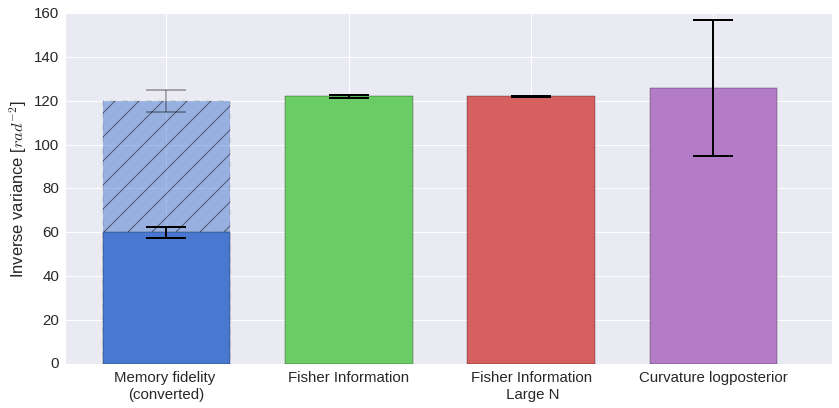

In [109]:
values_to_plot = [('Memory fidelity \n(converted)', 'mem_fidelity_as_fisher'),
                  ('Fisher Information', 'result_FI_rc_theo'),
#                   ('Fisher Information\ntheoretical covariance', 'result_FI_rc_theocov'),
#                   ('Marginal Fisher Information', 'marginal_inv_FI_inv'),
                  ('Fisher Information\n Large N', 'result_FI_rc_theo_largeN'),
                  ('Curvature logposterior', 'result_FI_rc_curv')
               ]

values_dict = extract_fisherinfo_values(experiment_launcher, values_to_plot)

ax = bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'])
ax.set_ylabel("Inverse variance [$rad^{-2}$]")
plt.tight_layout()
dataio.save_current_figure('fisherinfo_comparison_{label}_{unique_id}.pdf')

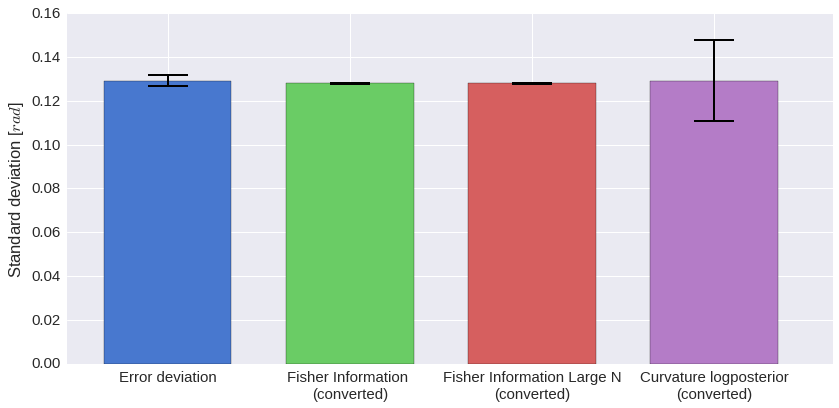

In [110]:
values_to_plot = [('Error deviation', 'mem_fidelity'),
                  ('Fisher Information \n(converted)', 'FI_theo_as_memfidelity'),
#                   ('Marginal Fisher Information', 'marginal_inv_FI_as_memfidelity'),
                  ('Fisher Information Large N\n(converted)', 'FI_theo_largeN_as_memfidelity'),
                  ('Curvature logposterior\n(converted)', 'FI_curv_as_memfidelity')
               ]

values_dict = extract_fisherinfo_values(experiment_launcher, values_to_plot)
ax = bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'], mem_fidelity_bar=False)
ax.set_ylabel("Standard deviation [$rad$]")
plt.tight_layout()
dataio.save_current_figure('fisherinfo_stddev_{label}_{unique_id}.pdf')

In [ ]:
distance_space = np.linspace(0, 1., 1000)

theta_space, inv_fi_distance, fi_distance = marginal_fi_distance_effect_twoitems(sampler, nSamples=10000)
plot_marginal_fi_comparions(distance_space, theta_space, fi_distance, inv_fi_distance)

dataio.save_current_figure('margfisherinfo_disteffectFI_{label}_{unique_id}.pdf')

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True)
utils.pcolor_2d_data(sampler.noise_covariance, cmap=cmap)

In [ ]:
utils.pcolor_2d_data(sampler.compute_covariance_theoretical(), cmap=cmap)

In [ ]:
sns.set_palette('dark')
sampler.plot_likelihood_correctlycuedtimes(should_exponentiate=True, n=9)

In [ ]:
n=9
sampler.plot_likelihood_variation_twoangles(should_exponentiate=False, n=n, colormap=cmap)

The KL Covariance thing needs to be checked, there's an error somewhere.

Basically:

- with random stimuli, we need to take the covariance of mu(theta) into account, as we are effectively marginalising over possible items when computing Sigma_noise
- With constant stimuli, the covariance should be 0, as we are marginalising over a delta.

I'm pretty sure I could capture that properly? Or just means that in constant stimuli situation, we have another recall posterior, and another Fisher? Feels weird, even perhaps the noise_covariance is wrong for a single item, and we shouldn't really compute the covariance over N items but N-1? Naah, not sure. Hence it's two posteriors?


** ==> Fixed it. The issue was really in which Covariance we were using in the recall posterior approximation. It was wrong; we were marginalising over $\phi$ and $\psi$ in the single item case (so the noise covariance was overly bad somehow), which shouldn't happen. **

### Need to restart fit_experiments though now!
### ... hope it still works :/

## => It does, all good :)

## Small M test

In [6]:
arguments_dict = dict(
    action_to_do='launcher_check_fisher_fit_1obj_2016',
    inference_method='sample',
    N=100,
    num_samples=50,
    M=3**2,
    label='thesis_fisherinfo_fit_1obj_smallM',
    output_directory='./Experiments/fisherinfo_singleitem/thesisrerun_fisherinfo_fit_1obj_050816',
    T=1,
    num_repetitions=5,
    renormalize_sigma=None,
    autoset_parameters=None,
    code_type='conj',
    ratio_conj=1.,
    sigmax=0.25,
    sigmay=0.000001,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=100,
    enforce_min_distance=0.17,
    specific_stimuli_random_centers=None,
    stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)
with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher_small = ExperimentLauncher(run=True, arguments_dict=arguments_dict)

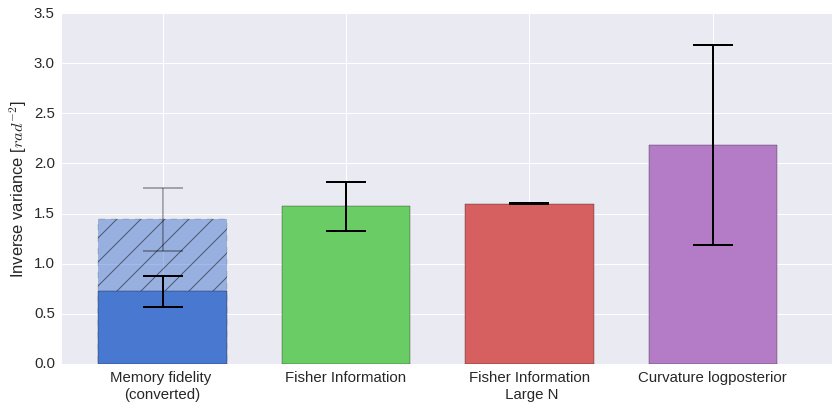

In [10]:
values_to_plot = [('Memory fidelity \n(converted)', 'mem_fidelity_as_fisher'),
                  ('Fisher Information', 'result_FI_rc_theo'),
#                   ('Fisher Information\ntheoretical covariance', 'result_FI_rc_theocov'),
#                   ('Marginal Fisher Information', 'marginal_inv_FI_inv'),
                  ('Fisher Information\n Large N', 'result_FI_rc_theo_largeN'),
                  ('Curvature logposterior', 'result_FI_rc_curv')
               ]

values_dict = extract_fisherinfo_values(experiment_launcher_small, values_to_plot)

ax = bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'])
ax.set_ylabel("Inverse variance [$rad^{-2}$]")
plt.tight_layout()

experiment_launcher_small.all_vars['dataio'].save_current_figure('fisherinfo_comparison_{label}_{unique_id}.pdf')

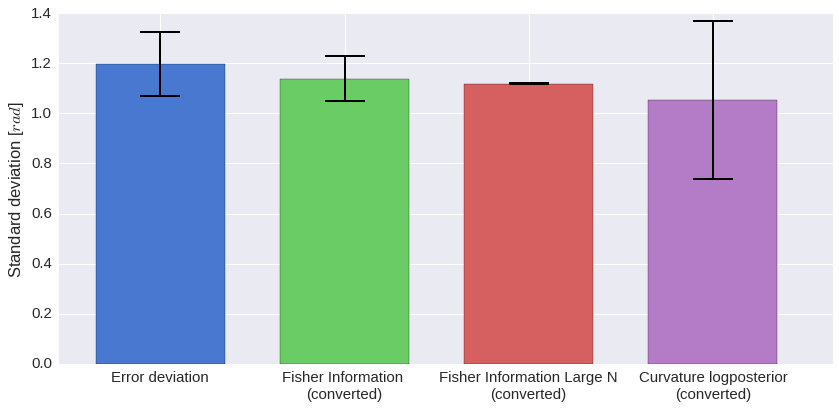

In [11]:
values_to_plot = [('Error deviation', 'mem_fidelity'),
                  ('Fisher Information \n(converted)', 'FI_theo_as_memfidelity'),
#                   ('Marginal Fisher Information', 'marginal_inv_FI_as_memfidelity'),
                  ('Fisher Information Large N\n(converted)', 'FI_theo_largeN_as_memfidelity'),
                  ('Curvature logposterior\n(converted)', 'FI_curv_as_memfidelity')
               ]

values_dict = extract_fisherinfo_values(experiment_launcher_small, values_to_plot)
ax = bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'], mem_fidelity_bar=False)
ax.set_ylabel("Standard deviation [$rad$]")
plt.tight_layout()
experiment_launcher_small.all_vars['dataio'].save_current_figure('fisherinfo_stddev_{label}_{unique_id}.pdf')

In [ ]:
sampler = experiment_launcher.all_vars['sampler']
n = 1

print "FI circulant:", sampler.random_network.compute_fisher_information_circulant(
    sampler.data_gen.stimuli_correct[n, sampler.tc[n]], sampler.noise_covariance)
print "FI normal:", sampler.random_network.compute_fisher_information(
    stimulus_input=sampler.data_gen.stimuli_correct[n, sampler.tc[n]], inv_cov_stim=sampler.inv_covariance_fixed_contrib)

---

---

---

---


# T>1 Items situation

### Fits work as well it seems, apart from the Large N limit, which doesn't use the full covariance, hence overestimates it.

In [ ]:
arguments_dict = dict(
    action_to_do='launcher_check_fisher_fit_1obj_2016',
    collect_responses=None,
    inference_method='sample',
    N=200,
    num_samples=50,
    M=14**2,
    T=1,
    num_repetitions=3,
    renormalize_sigma=None,
    autoset_parameters=None,
    code_type='conj',
    label='thesis_fisherinfo_fit_conj',
    output_directory='./Experiments/fisherinfo_singleitem/thesisrerun_fisherinfo_fit_multiobj_050816',
    ratio_conj=1.,
    sigmax=0.2,
    sigmay=0.000001,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=100,
    enforce_min_distance=0.17,
    specific_stimuli_random_centers=None,
    stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)

In [ ]:
all_experiment_launcher = []

T_space = np.arange(1, 2)

for T in progress.ProgressDisplay(T_space):
    print "==== Doing T=%d ====" % T
    arguments_dict['T'] = T
    
    with io.capture_output(display=False, stdout=True) as captured:
        all_experiment_launcher.append(ExperimentLauncher(run=True, arguments_dict=arguments_dict))

[0%] --
==== Doing T=1 ====
[20%] 5m42s
==== Doing T=2 ====
[40%] 4m34s
==== Doing T=3 ====


In [ ]:
values_to_plot = [('Memory fidelity \n(converted)', 'mem_fidelity_as_fisher'),
                  ('Fisher Information', 'result_FI_rc_theo'),
#                   ('Fisher Information\ntheoretical covariance', 'result_FI_rc_theocov'),
                  ('Marginal Fisher Information', 'marginal_FI'),
                  ('Fisher Information\n Large N', 'result_FI_rc_theo_largeN'),
                  ('Curvature logposterior', 'result_FI_rc_curv')
               ]

f, axes = plt.subplots(T_space.size, 1, figsize=(12, 5*T_space.size))


for T_i, T in enumerate(T_space):
    values_dict = extract_fisherinfo_values(all_experiment_launcher[T_i], values_to_plot)
    bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'], ax=axes[T_i])
    
    axes[T_i].set_ylabel("T = %d" % T, fontsize=30)
    
all_experiment_launcher[T_i].all_vars['dataio'].save_current_figure("fisherinfo_kappa_T%d_{label}_{unique_id}.pdf" % T)

In [ ]:
distance_space = np.linspace(0, 1., 1000)

sampler = all_experiment_launcher[1].all_vars['sampler']
theta_space, inv_fi_distance, fi_distance = marginal_fi_distance_effect_twoitems(sampler, nSamples=10000)
plot_marginal_fi_comparions(distance_space, theta_space, fi_distance, inv_fi_distance)

## Mixed code

In [23]:
arguments_dict['code_type'] = 'mixed'
arguments_dict['ratio_conj'] = 0.7
arguments_dict['num_repetitions'] = 1
arguments_dict['label'] = 'thesis_fisherinfo_fit_conj'

T_space = np.array([2])

all_experiment_launcher_mixed = []
for T in progress.ProgressDisplay(T_space):
    print "==== Doing T=%d ====" % T
    arguments_dict['T'] = T
    
    with io.capture_output(display=False, stdout=True) as captured:
        all_experiment_launcher_mixed.append(ExperimentLauncher(run=True, arguments_dict=arguments_dict))


[0%] --
==== Doing T=2 ====
[100%] 46s


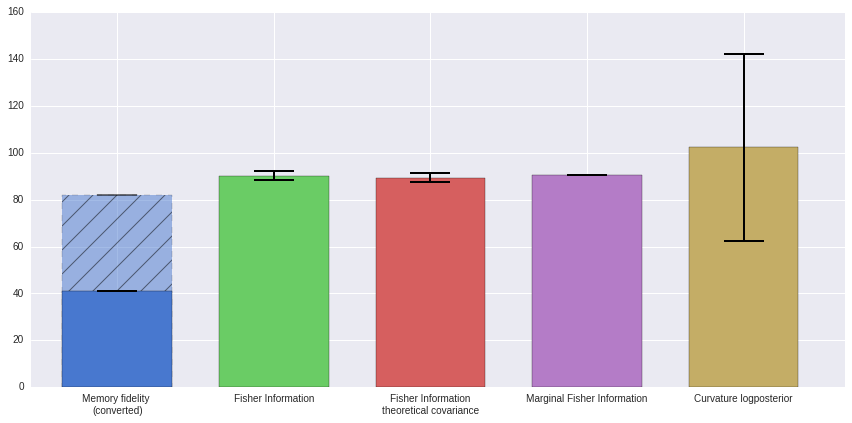

In [24]:
values_to_plot = [('Memory fidelity \n(converted)', 'mem_fidelity_as_fisher'),
                  ('Fisher Information', 'result_FI_rc_theo'),
#                   ('Fisher Information\ntheoretical covariance', 'result_FI_rc_theocov'),
#                   ('Marginal Fisher Information', 'marginal_FI'),
                  ('Curvature logposterior', 'result_FI_rc_curv')
               ]
values_dict = extract_fisherinfo_values(all_experiment_launcher_mixed[0], values_to_plot)
bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'])
    
# f, axes = plt.subplots(T_space.size, 1, figsize=(10, 5*T_space.size))

# for T_i, T in enumerate(T_space):
#     values_dict = extract_fisherinfo_values(all_experiment_launcher_mixed[T_i], values_to_plot)
#     bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'], ax=axes[T_i])
    
#     axes[T_i].set_ylabel("T = %d" % T, fontsize=30)

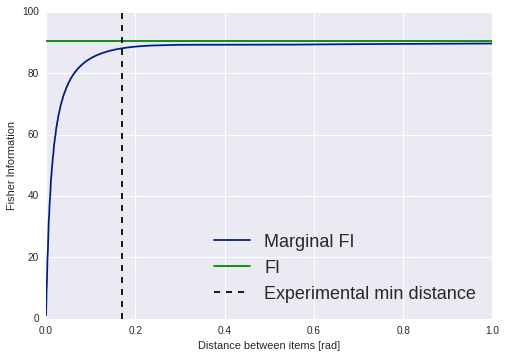

In [25]:
sampler = all_experiment_launcher_mixed[0].all_vars['sampler']
theta_space, inv_fi_distance, fi_distance = marginal_fi_distance_effect_twoitems(sampler, nSamples=10000)
plot_marginal_fi_comparions(distance_space, theta_space, fi_distance, inv_fi_distance)

## Playing with Covariance KL and circulant property

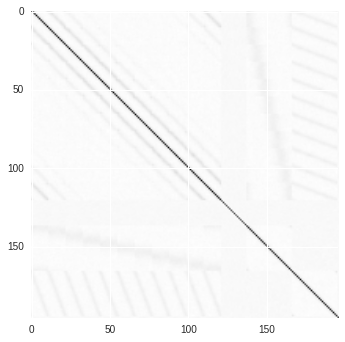

In [26]:
plt.imshow(sampler.noise_covariance)

In [27]:
print "FI circulant", np.mean(sampler.estimate_fisher_info_circulant())
print "FI classic", np.mean(sampler.estimate_fisher_info_theocov(use_theoretical_cov=False))

FI circulant 88.791237028
FI classic 90.1721276164


## Checking weird situation where FI doesn't follow Kappa if ratio=0.7 with T=2 ...

In [28]:
arguments_dict = dict(
    action_to_do='launcher_check_fisher_fit_1obj_2016',
    collect_responses=None,
    inference_method='sample',
    N=200,
    num_samples=50,
    M=400,
    T=2,
    num_repetitions=5,
    renormalize_sigma=None,
    autoset_parameters=None,
    label='thesis_fisherinfo_fit_ratioconj07',
    code_type='mixed',
    output_directory='./Experiments/fisherinfo_singleitem/thesisrerun_fisherinfo_fit_multiobj_050816',
    ratio_conj=0.7,
    sigmax=0.25,
    sigmay=0.000001,
    sigma_baseline=0.0,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=100,
    enforce_min_distance=0.17,
    specific_stimuli_random_centers=None,
    stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)
with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher_ratio07 = ExperimentLauncher(run=True, arguments_dict=arguments_dict)

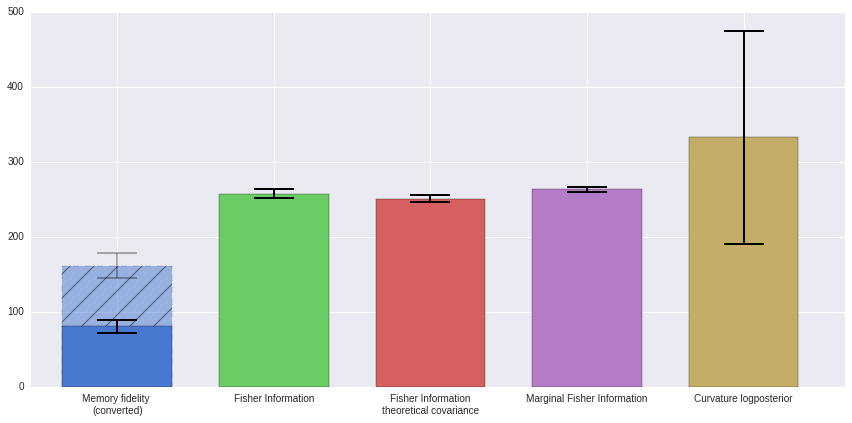

In [29]:
values_to_plot = [('Memory fidelity \n(converted)', 'mem_fidelity_as_fisher'),
                  ('Fisher Information', 'result_FI_rc_theo'),
                  ('Fisher Information\ntheoretical covariance', 'result_FI_rc_theocov'),
                  ('Marginal Fisher Information', 'marginal_FI'),
                  ('Curvature logposterior', 'result_FI_rc_curv')
               ]

values_dict = extract_fisherinfo_values(experiment_launcher_ratio07, values_to_plot)
bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'])

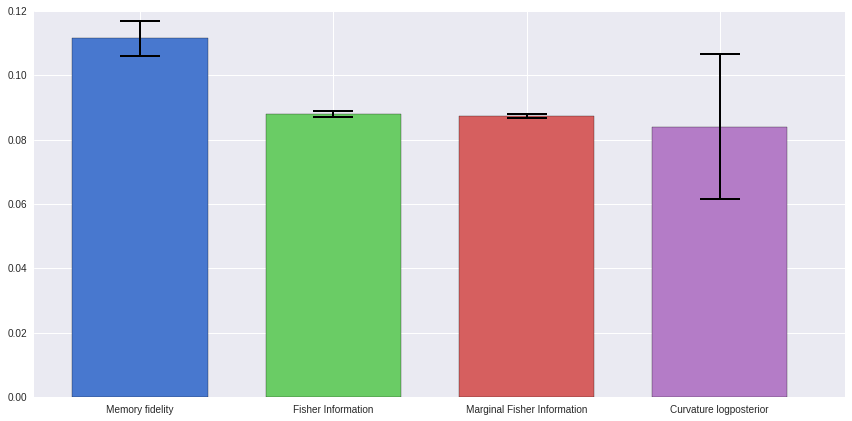

In [30]:
values_to_plot = [('Memory fidelity', 'mem_fidelity'),
                  ('Fisher Information', 'FI_theo_as_memfidelity'),
                  ('Marginal Fisher Information', 'marginal_inv_FI_as_memfidelity'),
                  ('Curvature logposterior', 'FI_curv_as_memfidelity')
               ]

values_dict = extract_fisherinfo_values(experiment_launcher_ratio07, values_to_plot)
bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'], mem_fidelity_bar=False)

In [31]:
sampler = experiment_launcher_ratio07.all_vars['sampler']

True angles: 0.521 | 2.760 >> Inferred: 0.490 | 2.790


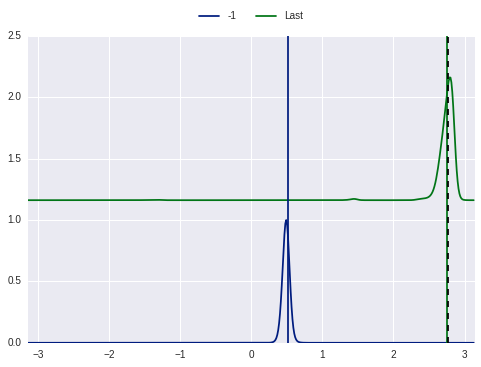

In [32]:
sampler.plot_likelihood_correctlycuedtimes(n=10)

In [33]:
sampler.fit_mixture_model()

{'K': 1.0,
 'aic': -180.03641602518178,
 'bic': -166.84314655898964,
 'kappa': 80.720266461631084,
 'mixt_nontargets': 0.034955745438428061,
 'mixt_nontargets_sum': 0.034955745438428061,
 'mixt_random': 0.026576085259206784,
 'mixt_target': 0.9384681693023651,
 'train_LL': 94.01820801259089}